2D poisson Computational Physics

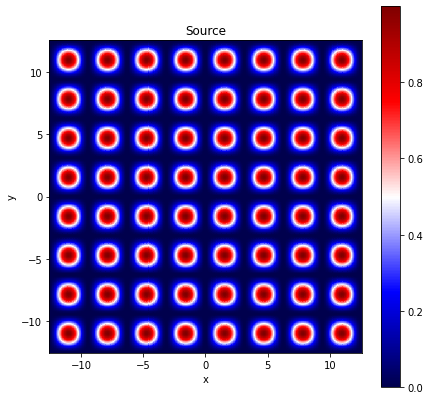

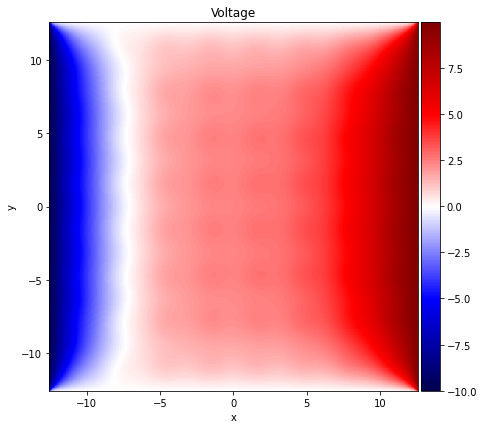

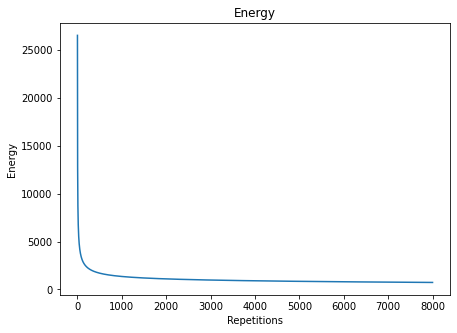

Energy =  730.3483597405714


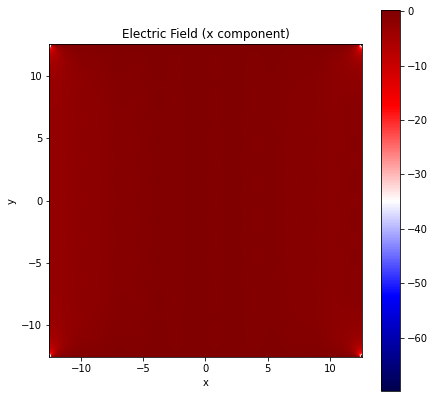

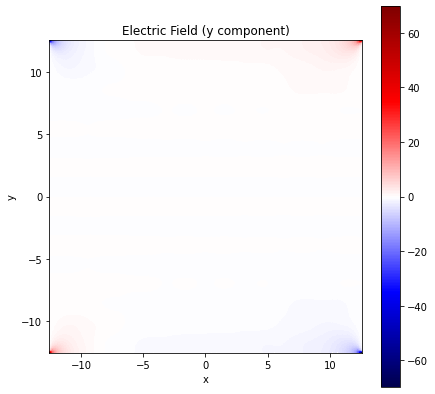

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numba import jit

#number of approximations
reps=8000
#resolutionx resolutiony number of points in each axis
step=0.05
boundaries=np.array([[-4*np.pi,4*np.pi],[-4*np.pi,4*np.pi]]) #(x1,x2) , (y1,y2) 

#necessary Initializations
resolutionx,resolutiony=int((boundaries[0,1]-boundaries[0,0])/step),int((boundaries[1,1]-boundaries[1,0])/step)
x=np.linspace(boundaries[0,0],boundaries[0,1],resolutionx)
y=np.linspace(boundaries[1,0],boundaries[1,1],resolutiony)
X,Y=np.meshgrid(x,y,indexing="ij")
voltage=np.zeros((resolutionx,resolutiony))
electricField=np.zeros((resolutionx,resolutiony,2))
source=np.zeros((resolutionx,resolutiony))
for i in range(resolutionx):
  for j in range(resolutiony):
                 source[i,j]=np.exp(-x[i]**2)+np.exp(-y[j]**2)

#boundary conditions
#x sides 
voltage[:,0]=0
voltage[:,resolutiony-1]=0
#y sides
voltage[0,:]=-10
voltage[resolutionx-1,:]=10

#Charge Distribution
source=np.sin(X)**2*np.sin(Y)**2

#choosing colormap
cmap=cm.get_cmap("seismic")

#plotting the Source
plt.figure(figsize=[7,7])
plt.pcolormesh(X, Y, source, cmap=cmap)
plt.title("Source")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.gca().set_aspect('equal')   
plt.savefig("source.png")  
plt.show()

def plotVoltage(X, Y, voltage):
  fig, ax=plt.subplots(figsize=(7,7))
  im=ax.pcolormesh(X, Y, voltage, cmap=cm.get_cmap("seismic"))
  ax.set_title("Voltage")
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_aspect("equal")
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(im, cax=cax)
#  fig.colorbar(im)
  fig.savefig("2-D Poisson Conv.png")
  return

#Approximating voltage
@jit(nopython=True)
def calculate(reps, resolutionx, resolutiony, step, source, voltage, X, Y):
  energy=np.zeros(reps)
  for n in range(reps):
      sum1=sum2=0
      for i in range(1,resolutionx-1):
          for j in range(1,resolutiony-1):
              voltage[i,j]=(voltage[i+1,j]+voltage[i-1,j]+voltage[i,j+1]+voltage[i,j-1]+np.power(step,2)*source[i,j])/4
      #calculating energy
      for i in range(1,resolutionx):
              for j in range(1,resolutiony):
                  sum1+=np.power((voltage[i,j]-voltage[i-1,j]),2)+np.power((voltage[i,j]-voltage[i,j-1]),2)
                  if i!=resolutionx or j!=resolutiony:    
                      sum2+=source[i,j]*voltage[i,j]
      energy[n]=0.5*sum1-np.power(step,2)*sum2

  return voltage,energy

voltage, energy=calculate(reps, resolutionx, resolutiony, step, source, voltage, X, Y)
plotVoltage(X, Y, voltage)

np.save("convVoltage.npy", voltage)
np.save("y.npy", y)
np.save("x.npy", x)

#Plotting Energy
plt.figure(figsize=[7,5])
plt.plot(energy)
plt.title("Energy")
plt.xlabel("Repetitions")
plt.ylabel("Energy")
plt.show()
print("Energy = ",energy[-1])

#computing electric field
for i in range(1,resolutionx-1):
    for j in range(1,resolutiony-1):
        electricField[i,j,0]=-0.5*(voltage[i+1,j]-voltage[i-1,j])/step
        electricField[i,j,1]=-0.5*(voltage[i,j+1]-voltage[i,j-1])/step

plt.figure(figsize=[7,7])
plt.pcolormesh(X,Y,electricField[:,:,0],cmap=cmap)
plt.title("Electric Field (x component)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.gca().set_aspect('equal', 'box')     
plt.show()

plt.figure(figsize=[7,7])
plt.pcolormesh(X,Y,electricField[:,:,1],cmap=cmap)
plt.title("Electric Field (y component)")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.gca().set_aspect('equal', 'box')     
plt.show()


Plotting functions

In [ ]:
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plotHistory(loss_and_error_history):
  fig, ax=plt.subplots(figsize=(12,7))
  ax.plot(loss_and_error_history[:, 0], label="Loss")
  ax.plot(loss_and_error_history[:, 1], label="Error")
  fig.legend()
  ax.set_title('History (Final Error: {:.3f})'.format(loss_and_error_history[-1,1]), fontsize = 10)
  

def plotResults(model, limits, data):
  lb=np.array([limits[0], limits[2]])  #lower bounds
  ub=np.array([limits[1],limits[3]])   #upper bounds
  x=np.linspace(lb[0], ub[0], 200)
  y=np.linspace(lb[1], ub[1], 200)
  X,Y=np.meshgrid(x,y,indexing="ij")
  X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
  u_pred=model(X_star)
  U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, Y), method='cubic')
  x_train=data[0]

  # Creating the figure
  fig, ax=plt.subplots(figsize=(7,7))

  #  ax = plt.subplot(gs0[:, :])

  h = ax.imshow(U_pred.T, interpolation='nearest', cmap=cm.get_cmap("seismic"), 
                extent=[x.min(), x.max(), y.min(), y.max()], 
                origin='lower', aspect='auto')
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  fig.colorbar(h, cax=cax)

  ax.plot(x_train[:,0], x_train[:,1], 'kx', label = 'Data (%d points)' % (x_train.shape[0]), markersize = 4, clip_on = False)
  ax.set_aspect("equal")

  #  line = np.linspace(x.min(), x.max(), 2)[:,None]
  #  ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
  #  ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
  #  ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.legend(frameon=False, loc = 'best')
  ax.set_title('u(x,y)', fontsize = 10)
  fig.savefig("2-D Poisson PINN.png")



2D poisson PINN


In [ ]:
%tensorflow_version 2.x
import math

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata



###random sampling from a line
def sample(fro , to, frequency):   #returns frequency number of samples per unit of length
  return np.random.random_sample( frequency)*(to-fro)+fro

def sample_from_square(limits, sampling_density): 
###limits: tuple that holds the limits of the rectangle i.e. (-1,1,-2,2 ) for a rectangle from x=-1 to x=1 and y=-2 to y=2
###sampling_density: number of points per unit surface

  number_of_points=int((limits[1]-limits[0])*(limits[3]-limits[2])*sampling_density)
  x=np.random.random_sample(number_of_points)*(limits[1]-limits[0])+limits[0]
  y=np.random.random_sample(number_of_points)*(limits[3]-limits[2])+limits[2]
  toRet=np.zeros((number_of_points, 2))
  toRet[:,0]=x
  toRet[:,1]=y  
  return toRet

###obtain data by random sampling

def getDataUniformNoise(limits , boundary_conditions, sample_frequency, noise_amplitude=0):
###limits: tuple that holds the limits of the rectangle i.e. (-1,1,-2,2 ) for a rectangle from x=-1 to x=1 and y=-2 to y=2
###boundary_conditions: tuple holding the value of u at the sides of the rectangle in format (V1, V2, V3, V4). V1, V2 are the values at the bottom and top sides of the rectangle respectively and V3,V4 are the values at the left and right sides of the rectangle.
###sampling_frequency: integer holding samples per unit lengthReturn: tuple (xy, u)

  """Returns
  xy: numpy array of 2 axes.
  i.e. : [ [x1, y1], [x2, y2] ,....., [xn, yn] ]

  u: numpy array of one axis holding the value of u at coordinates x, y."""

  points=np.zeros((0,2))
  x1=sample(limits[0], limits[1], sample_frequency)
  x2=sample(limits[0], limits[1], sample_frequency)
  y1=sample(limits[2], limits[3], sample_frequency)
  y2=sample(limits[2], limits[3], sample_frequency)
  side1=np.zeros((len(x1), 2))
  side2=np.zeros((len(x2), 2))
  side3=np.zeros((len(y1), 2))
  side4=np.zeros((len(y2), 2))

  side1[:,0]=x1
  side1[:,1]=limits[2]
  side2[:,0]=x2
  side2[:,1]=limits[3]
  side3[:,0]=limits[0]
  side3[:,1]=y1
  side4[:,0]=limits[1]
  side4[:,1]=y2

  points=np.append(points, side1, 0)
  points=np.append(points, side2, 0)
  points=np.append(points, side3, 0)
  points=np.append(points, side4, 0)

  u=np.zeros((0))
  u1=np.ones(len(x1))*boundary_conditions[0]+np.random.uniform(-noise_amplitude, noise_amplitude, len(x1))
  u2=np.ones(len(x2))*boundary_conditions[1]+np.random.uniform(-noise_amplitude, noise_amplitude, len(x2))
  u3=np.ones(len(y1))*boundary_conditions[2]+np.random.uniform(-noise_amplitude, noise_amplitude, len(y1))
  u4=np.ones(len(y2))*boundary_conditions[3]+np.random.uniform(-noise_amplitude, noise_amplitude, len(y2))

  u=np.append(u, u1, 0)
  u=np.append(u, u2, 0)
  u=np.append(u, u3, 0)
  u=np.append(u, u4, 0)

  return points, u

def getDataNormalNoise(limits , boundary_conditions, sample_frequency, std=1):
###limits: tuple that holds the limits of the rectangle i.e. (-1,1,-2,2 ) for a rectangle from x=-1 to x=1 and y=-2 to y=2
###boundary_conditions: tuple holding the value of u at the sides of the rectangle in format (V1, V2, V3, V4). V1, V2 are the values at the bottom and top sides of the rectangle respectively and V3,V4 are the values at the left and right sides of the rectangle.
###sample_frequency: integer holding samples per unit lengthReturn: tuple (xy, u)
###std: Standard deviation of noise sampling.
  """Returns
  xy: numpy array of 2 axes.
  i.e. : [ [x1, y1], [x2, y2] ,....., [xn, yn] ]

  u: numpy array of one axis holding the value of u at coordinates x, y."""

  points=np.zeros((0,2))
  x1=sample(limits[0], limits[1], sample_frequency)
  x2=sample(limits[0], limits[1], sample_frequency)
  y1=sample(limits[2], limits[3], sample_frequency)
  y2=sample(limits[2], limits[3], sample_frequency)
  side1=np.zeros((len(x1), 2))
  side2=np.zeros((len(x2), 2))
  side3=np.zeros((len(y1), 2))
  side4=np.zeros((len(y2), 2))

  side1[:,0]=x1
  side1[:,1]=limits[2]
  side2[:,0]=x2
  side2[:,1]=limits[3]
  side3[:,0]=limits[0]
  side3[:,1]=y1
  side4[:,0]=limits[1]
  side4[:,1]=y2

  points=np.append(points, side1, 0)
  points=np.append(points, side2, 0)
  points=np.append(points, side3, 0)
  points=np.append(points, side4, 0)

  u=np.zeros((0))
  u1=np.ones(len(x1))*boundary_conditions[0]+np.random.normal(scale=std, size=len(x2))
  u2=np.ones(len(x2))*boundary_conditions[1]+np.random.normal(scale=std, size=len(x2))
  u3=np.ones(len(y1))*boundary_conditions[2]+np.random.normal(scale=std, size=len(y1))
  u4=np.ones(len(y2))*boundary_conditions[3]+np.random.normal(scale=std, size=len(y2))

  u=np.append(u, u1, 0)
  u=np.append(u, u2, 0)
  u=np.append(u, u3, 0)
  u=np.append(u, u4, 0)

  return points, u

###Visualizing Boundary and collocation points
def visualizePoints(data, x_coll):
  x_train=data[0]
  y_train=data[1]
  fig, ax=plt.subplots(figsize=[7,7])
  ax.plot(x_coll[:,0],x_coll[:,1],"r.")
  ax.plot(x_train[:,0],x_train[:,1],".", markersize=10)
  ax.set_title("Boundary and collocation points", fontsize = 10)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  fig.savefig("points.png")


#create the model
def createModel(limits):
  lb=np.array([limits[0], limits[2]])  #lower bounds
  ub=np.array([limits[1],limits[3]])   #upper bounds
  model=tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=(2,)))
  model.add(tf.keras.layers.Lambda(                           #scaling data to (0,1)
        lambda X: 2.0*(X - lb)/(ub - lb) - 1.0))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))

  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(20, activation="tanh"))
  model.add(tf.keras.layers.Dense(1, activation="tanh"))
  return model

#physics informed part
def f(X):
  x=tf.convert_to_tensor(X[:,0])
  y=tf.convert_to_tensor(X[:,1])
  with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    t.watch(y)
    u=model(tf.stack([x, y], axis=1))
    u_x=t.gradient(u, x)
    u_y=t.gradient(u, y)
    
  u_xx = t.gradient(u_x, x)
  u_yy = t.gradient(u_y, y)
    
  del t
  return u_xx + u_yy + tf.sin(x)**2*tf.sin(y)**2

 #Compare (metric), relative L2 norm of PINN and computational results
def error(model, X, Y, U):
  X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
  u_star=U.flatten()[:,None]
  u_pred=model(X_star)
  return np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

#train the model
def train(epochs, x_coll, data, model, optimizer, f, error, X, Y):
  # For each one of the iterations.
  xc=tf.constant(x_coll, tf.float32)
  loss_and_error_history=np.zeros((epochs, 2))
  for epoch in range(epochs): 
    with tf.GradientTape() as tape :
      y_predicted=model(data[0])
      loss = tf.reduce_mean(tf.square(f(xc))) + tf.reduce_mean(tf.square(data[1]-y_predicted)) ###loss function is MSE_u+MSE_f as shown in the paper
    #Loss and error history
    error_value=error(model, X, Y, voltage)
    loss_and_error_history[epoch, 0]=loss
    loss_and_error_history[epoch, 1]=error_value
    if (epoch+1)%100==0:
      print("\nEpoch: {}, Loss: {:.3e}, Error: {:.3e}".format(epoch+1, loss.numpy(), error_value, end = ""))
    
    grads = tape.gradient(loss, model.trainable_variables) # Calculate the derivatives.
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) # Back propagations.
  return loss_and_error_history




Example



Epoch: 100, Loss: 5.014e+01, Error: 9.979e-01

Epoch: 200, Loss: 5.014e+01, Error: 1.001e+00

Epoch: 300, Loss: 5.014e+01, Error: 9.991e-01

Epoch: 400, Loss: 5.014e+01, Error: 9.999e-01

Epoch: 500, Loss: 5.014e+01, Error: 1.001e+00


KeyboardInterrupt: ignored

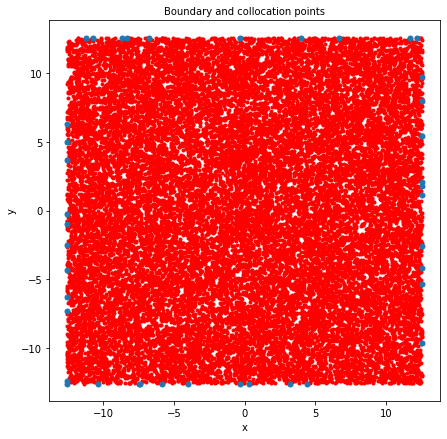

In [ ]:
pi=float(np.pi)
###obtain data and coordinates of collocation points
boundary_sampling_frequency=10 #sampling frequency (points per unit length)
collocation_density=40      #sampling frequency of collocation points  (points per square unit of length)

limits=(-4*pi, 4*pi, -4*pi, 4*pi) 
boundary_conditions=(0,0,-10,10)

epochs=3000

data=getDataUniformNoise(limits, boundary_conditions, boundary_sampling_frequency)
x_coll=sample_from_square(limits, collocation_density)

visualizePoints(data, x_coll)

#choose optimizer
optimizer = tf.keras.optimizers.Adam(
  learning_rate=0.1,
  beta_1=0.99,
  epsilon=1e-1)

model=createModel(limits)

#train
loss_and_error_history=train(epochs, x_coll, data, model, optimizer, f, error, X, Y)

#visualize training
plotHistory(loss_and_error_history)
plotResults(model, limits, data)

In [ ]:
visualizePoints(data, x_coll)